In [18]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (basal area, QMD, TPA, etc.)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif')
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
# Grab some raster metadata
shp, gt, wkt, nd = treemap_da.shape, treemap_da.spatial_ref.GeoTransform, treemap_da.rio.crs, treemap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {treemap_da[0].dtype}")
gc.collect() # clean up

Shape: (97383, 154221); 
GeoTransform: -2362845.0 30.0 0.0 3180555.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float64


60

In [3]:
# load and prepare our study region for cropping TreeMap
# Southern Rockies ecoregion bounds (buffered)
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_srme.gpkg')
srm = gpd.read_file(fp)
# Crop the raster by the SRM bounds
bounds = srm.total_bounds # total bounds of ecoregion
treemap_da_c = treemap_da.rio.clip_box(
    minx=bounds[0]+10000, # +10km buffer
    miny=bounds[1]+10000, 
    maxx=bounds[2]+10000, 
    maxy=bounds[3]+10000
)
print(f"Cropped TreeMap to SRM bounds w/ 10km buffer.")
del treemap_da, bounds
gc.collect() # clean up

Cropped TreeMap to SRM bounds w/ 10km buffer.


54

In [4]:
# load the aggregated FRP grid
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry'],
      dtype='object')

In [5]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_tmid = compute_band_stats(grid, treemap_da_c, 'grid_index', attr='tm_id')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 0.52 minutes.

~~~~~~~~~~



In [6]:
# tidy columns
grid_tmid['count'] = grid_tmid['count'].astype(int)
grid_tmid['total_pixels'] = grid_tmid['total_pixels'].astype(int)
grid_tmid.rename(columns={'total_pixels': 'forest_pixels'}, inplace=True)
grid_tmid.head()

,grid_index,tm_id,count,forest_pixels,pct_cover
0,1955419,12665,3,169,1.775148
1,1955419,20313,5,169,2.958580
2,1955419,45478,8,169,4.733728
3,1955419,46099,1,169,0.591716
4,1955419,51905,5,169,2.958580


In [7]:
# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
tree_tbl.columns

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')

In [8]:
# join to the grid data
grid_trees = grid_tmid.merge(tree_tbl, on='tm_id', how='left')
grid_trees.head()

,grid_index,tm_id,count,forest_pixels,pct_cover,CN,STATUSCD,TPA_UNADJ,SPCD,COMMON_NAME,SCIENTIFIC_NAME,SPECIES_SYMBOL,DIA,HT,ACTUALHT,CR,SUBP,TREE,AGENTCD
0,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,202,Douglas-fir,Pseudotsuga menziesii,PSME,6.5,31.0,31.0,83.0,2,1,NaN
1,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,122,ponderosa pine,Pinus ponderosa,PIPO,14.4,46.0,46.0,25.0,1,1,NaN
2,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,202,Douglas-fir,Pseudotsuga menziesii,PSME,5.4,14.0,14.0,65.0,1,2,NaN
3,1955419,12665,3,169,1.775148,11746831010690,1,74.965280,202,Douglas-fir,Pseudotsuga menziesii,PSME,4.0,15.0,15.0,70.0,1,3,NaN
4,1955419,12665,3,169,1.775148,11746831010690,1,6.018046,202,Douglas-fir,Pseudotsuga menziesii,PSME,7.9,33.0,33.0,78.0,2,2,NaN


In [10]:
# Calculate the live basal area for the tree table
# force species name to lower case
grid_trees['COMMON_NAME'] = grid_trees['COMMON_NAME'].str.lower()
# subset to live trees, calculate basal area
live_trees = grid_trees[grid_trees['STATUSCD'] == 1]
live_trees['BA'] = np.pi * (live_trees['DIA'] / 2) ** 2  # Basal area in square feet
live_trees['BA_sc'] = live_trees['BA'] * live_trees['TREE'] * live_trees['TPA_UNADJ'] # adjust based on tree counts
ba_by_species = (
    live_trees.groupby(['grid_index', 'tm_id', 'COMMON_NAME'])['BA_sc']
    .sum()
    .reset_index()
    .rename(columns={'BA_sc': 'balive'})
)
ba_by_species.head()

,grid_index,tm_id,COMMON_NAME,balive
0,183297,5447,common or two-needle pinyon,9079.820663
1,183297,5447,utah juniper,5426.140758
2,183297,13033,common or two-needle pinyon,2454.214985
3,183297,13033,utah juniper,11018.798305
4,183297,41520,utah juniper,4387.336901


In [11]:
# identify the dominant forest species for each "tm_id"
spp_dominance = (
    ba_by_species.groupby(['tm_id', 'COMMON_NAME'])['balive']  # based on live basal area
    .sum()
    .reset_index()
    .sort_values(['tm_id', 'balive'], ascending=[True, False])
    .drop_duplicates('tm_id')  # Keep only the top species per tm_id
)

# join back to the tm_id summary
grid_tmid_spp = grid_tmid.merge(spp_dominance[['tm_id', 'COMMON_NAME']], on='tm_id', how='left')

# identify the landscape proportion of dominant species
spp_pr = (
    grid_tmid_spp.groupby('COMMON_NAME')['count']
    .sum()
    .reset_index()
    .rename(columns={'count': 'maj_spp_count'})
    .sort_values(by='maj_spp_count', ascending=False)
)

# calculate the fraction
spp_pr['fraction'] = spp_pr['maj_spp_count'] / spp_pr['maj_spp_count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# Identify species contributing 97% of the burned area
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.99]
print(f"\nSpecies contributing to 97% of the burned area:\n{top_species}\n")


Species contributing to 97% of the burned area:
                    COMMON_NAME  maj_spp_count  fraction  c_fraction
38               lodgepole pine        2176450  0.257621    0.257621
50               ponderosa pine        2030381  0.240331    0.497953
51                quaking aspen         875354  0.103614    0.601566
26             engelmann spruce         701507  0.083036    0.684602
61                subalpine fir         577904  0.068405    0.753007
22                  douglas-fir         511310  0.060523    0.813530
28                   gambel oak         312903  0.037038    0.850568
73                    white fir         255007  0.030185    0.880752
29                    grand fir         206678  0.024464    0.905216
67                 utah juniper         145775  0.017255    0.922471
18  common or two-needle pinyon         144283  0.017078    0.939550
56       rocky mountain juniper         109132  0.012918    0.952467
36                 jeffrey pine          95754  0.0113

In [12]:
# do some species regrouping and renaming
spp_grouping = {
    'pinyon|juniper': 'pinon-juniper',
    ' fir|spruce': 'spruce-fir',
    'ponderosa pine': 'ponderosa',
    'lodgepole pine': 'lodgepole'
}

spp_remap = {}
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_trees[grid_trees['COMMON_NAME'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['COMMON_NAME'].unique()})

# Apply the remap to create a new grouped species column
grid_trees['SpeciesGroup'] = grid_trees['COMMON_NAME'].map(spp_remap).fillna(grid_trees['COMMON_NAME'])

# Verify the updated species groups
print(grid_trees[['COMMON_NAME', 'SpeciesGroup']].drop_duplicates().head(10))

          COMMON_NAME   SpeciesGroup
0         douglas-fir    douglas-fir
1      ponderosa pine      ponderosa
8      lodgepole pine      lodgepole
17        limber pine    limber pine
21      quaking aspen  quaking aspen
31          grand fir     spruce-fir
44      western larch  western larch
53          white fir     spruce-fir
108  engelmann spruce     spruce-fir
119      corkbark fir     spruce-fir


In [13]:
# merge the live basal area
grid_trees = grid_trees.merge(ba_by_species, on=['grid_index', 'tm_id', 'COMMON_NAME'], how='left')
grid_trees[['grid_index','tm_id','count','COMMON_NAME','balive']].head(10)

,grid_index,tm_id,count,COMMON_NAME,balive
0,1955419,12665,3,douglas-fir,34422.862428
1,1955419,12665,3,ponderosa pine,2123.928024
2,1955419,12665,3,douglas-fir,34422.862428
3,1955419,12665,3,douglas-fir,34422.862428
4,1955419,12665,3,douglas-fir,34422.862428
5,1955419,12665,3,douglas-fir,34422.862428
6,1955419,12665,3,douglas-fir,34422.862428
7,1955419,12665,3,ponderosa pine,2123.928024
8,1955419,12665,3,lodgepole pine,1933.353033
9,1955419,12665,3,douglas-fir,34422.862428


In [14]:
# Collapse the tree data to species
row_counts = (
    grid_trees.groupby(['grid_index', 'tm_id', 'COMMON_NAME'])
    .size()
    .reset_index(name='tree_count')  # Name the count column 'tree_count'
)
# Merge the tree_count back into the original grid_trees DataFrame
grid_trees_sp = grid_trees.merge(row_counts, on=['grid_index', 'tm_id', 'COMMON_NAME'], how='left')
grid_trees_sp = grid_trees_sp.drop_duplicates(subset=['grid_index', 'tm_id', 'COMMON_NAME'])
grid_trees_sp[['grid_index', 'tm_id', 'COMMON_NAME', 'SpeciesGroup', 'tree_count', 'balive']].head(10)

,grid_index,tm_id,COMMON_NAME,tree_count,balive
0,1955419,12665,douglas-fir,22,34422.862428
1,1955419,12665,ponderosa pine,3,2123.928024
8,1955419,12665,lodgepole pine,2,1933.353033
17,1955419,12665,limber pine,1,10345.783103
21,1955419,12665,quaking aspen,3,11926.900277
31,1955419,20313,grand fir,14,18172.700420
32,1955419,20313,douglas-fir,6,22086.606882
44,1955419,20313,western larch,1,703.501529
52,1955419,45478,douglas-fir,12,16230.778526
53,1955419,45478,white fir,19,56528.284987



Species contributing to 97% of the burned area:
     SpeciesGroup  maj_spp_count  fraction  c_fraction
28      lodgepole        2160147  0.255692    0.255692
40      ponderosa        1997617  0.236453    0.492145
48     spruce-fir        1993621  0.235980    0.728125
41  quaking aspen         853791  0.101061    0.829186
38  pinon-juniper         569900  0.067458    0.896644
14    douglas-fir         389517  0.046106    0.942750
19     gambel oak         309792  0.036669    0.979420



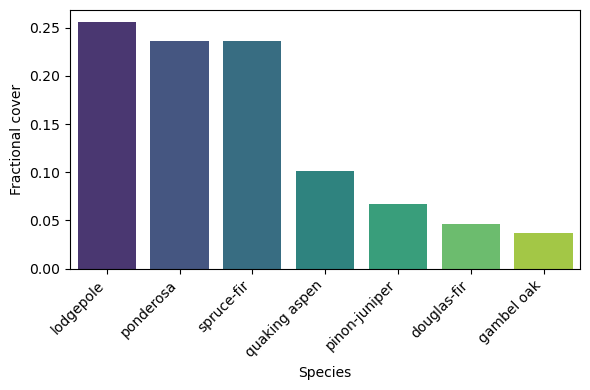

In [21]:
# identify the dominant forest species for each "tm_id"
spp_dominance = (
    grid_trees_sp.groupby(['tm_id', 'SpeciesGroup'])['balive']  # Sum tree counts (or use another metric)
    .sum()
    .reset_index()
    .sort_values(['tm_id', 'balive'], ascending=[True, False])
    .drop_duplicates('tm_id')  # Keep only the top species per tm_id
)

# join back to the tm_id summary
grid_tmid_spp = grid_tmid.merge(spp_dominance[['tm_id', 'SpeciesGroup']], on='tm_id', how='left')

# identify the landscape proportion of dominant species
spp_pr = (
    grid_tmid_spp.groupby('SpeciesGroup')['count']
    .sum()
    .reset_index()
    .rename(columns={'count': 'maj_spp_count'})
    .sort_values(by='maj_spp_count', ascending=False)
)

# calculate the fraction
spp_pr['fraction'] = spp_pr['maj_spp_count'] / spp_pr['maj_spp_count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# Identify species contributing 97% of the burned area
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.98]
print(f"\nSpecies contributing to 97% of the burned area:\n{top_species}\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesGroup', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
spp_pct_cover.head()

In [ ]:
# test tree table
tree_tbl[tree_tbl['tm_id'] == 21404][['tm_id','COMMON_NAME','DIA','HT','CR','TREE']]